# Overview

In this notebook, I worked out functions to simulate mocked runs for the fmri experiment, which contain the entire stimulus set (i.e. all intact object images and ri percepts).

I also work out functions for computing the efficiency of a given design and iterate over lots of simulated designs to find the most efficient one.

Efficiency in this context is tailored to the GLM contrasts we aim to calculate, e.g. intact objects vs. ri percepts, or trained vs. untrained ri percepts.

I then vary the parameters of the jitter to see if we can increase design efficiency further. As a result, we'll see that changing the jitter parameters has no effect on our design efficiency and we might just pick the most feasible jitter.

In [1]:
from mvpa2.misc.data_generators import simple_hrf_dataset

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# Definitions copied from my scripts

*You may jump to the next secion ('Generate run')*. These functions have nothing to do with the actual interesting efficiency calculation. We need them to generate a sequence of trials of a 1-back task.

In [114]:
# %load ../fmri_exp.py
#!/usr/bin/python

"""
Script for stimulus presentation in the scanner.
"""

import copy
import os
import random
from collections import OrderedDict
from os.path import join as pjoin

import numpy as np
from numpy.random import exponential
from psychopy import core, visual, event


def showinstr(instring='Weiter mit der Leertaste'):
    """
    Show instructions and wait for key press (space bar).

    Parameters
    ----------
    instring : str
        String you want to be presented as instructions.

    Returns
    -------
    None
    """

    # create and draw window, flip screen.
    win = visual.Window(color='black', units='pix', fullscr=True)  # size=(1680, 1050)
    text = visual.TextStim(win, text=instring, color='white', height=20)
    text.draw()
    win.flip()

    # await keyboard input and close screen.
    keys = event.waitKeys(keyList=['space', 'escape'])
    if 'escape' in keys:
        win.close()
    else:
        print 'End of instructions'
        win.close()


def checkconsec(integerlist):
    """
    Helper function.
    Check whether a list of integers contains consecutive numbers. Returns True or False.
    """
    # make an ordered copy of original input list
    ordered = [i for i in integerlist]
    ordered.sort()
    # check for consecutive list elements
    consec = False
    for element in ordered[1:]:
        if element == ordered[ordered.index(element) - 1] + 1:
            consec = True
    return consec


def checkfirstlast(indiceslist,
                   targetlist):
    """
    Check if list of indices contains index for first or last element of a target list
    (i.e. 0 or len(elementlist)-1 )
    """
    # check constraint
    firstlast = False
    lastidx = len(targetlist) - 1
    if 0 in indiceslist or lastidx in indiceslist:
        firstlast = True
    return firstlast


def assertplus2(list1, list2):
    """
    Assert if list1 has at least two more elements than list2
    """
    if len(list1) < len(list2) + 2:
        raise IOError('Too many catch trials for stimulus sequence, given constraint checkfirstlast.\n'
                      'length of stimulus list : %s\n'
                      'number of desired catch trials : %s'
                      % (str(len(list1)), str(len(list2))))
    return None


def add_empty_responses(stimsequence,
                        add_empty_onset=True,
                        add_trial_num=True):
    """
    Add empty dummy information for the to-be-captured responses to each stimulus dict in sequence. These are:
    Rt, accuracy, keys, trial_num, and ran. This will allow all trials with their information to be written in the
    logg-file even if they haven't run yet.
    
    To use this function on pre-generated sequences (from design optimization), that already have onsets and trial
    numbers, these keys may optionally not be added
    """
    for trial_num, stimdict in enumerate(stimsequence):
        if add_empty_onset:
            stimdict['global_onset_time'] = None
        stimdict['RT'] = None
        stimdict['accuracy'] = None
        stimdict['keys'] = None
        if add_trial_num:
            stimdict['trial_num'] = trial_num
        stimdict['ran'] = False
    return stimsequence


def add_catches(stimlist,
                num_catches=10,
                shuffle_inlist=True):
    """
    Add catch trials for a 1-back taks to a given stimulus sequence by repeating randomly chosen trials.
    Catch trials are not allowed To occur in first or last position of the sequence, nor can two catch trials follow
    one another. Also adds the "trial_type" key to each stimulus dict with values "normal" or "catch".
    """

    # assert that we didn't specify too many catch trials given our constraints
    assertplus2(stimlist, range(num_catches))
    # shuffle if desired
    if shuffle_inlist:
        random.shuffle(stimlist)
    # initial key-value indicating if this is a catch or normal trial
    for stim in stimlist:
        stim['trial_type'] = 'normal'

    # make list of random, non-consecutive positions for catch trials
    # with added constraint that first and last trials mustn't be catch trials
    consec_bool, firstlast_bool = True, True
    insert_positions = None
    while consec_bool or firstlast_bool:
        insert_positions = np.array(sorted(random.sample(range(len(stimlist)), num_catches)))
        consec_bool, firstlast_bool = checkconsec(insert_positions), checkfirstlast(insert_positions, stimlist)

    """
    insert catch stims. np inserts values before the given positions,
    so we mark everything in stimlist[catchpositions] as 'catch' and insert the as 'normal' tagged
    dicts from the catchstims copy before that.
    """    
    # make stimlist an array to get numpy goodness
    stimlist = np.array(stimlist)

    # copy so we don't have pointer problems
    catchstims = copy.deepcopy(stimlist[insert_positions])

    # insert their copies at the positions before
    stimlist_ins = np.insert(stimlist, insert_positions, catchstims)

    # mark catch trials trial_type
#    catch_counter = 0
#    for idx in range(len(stimlist_ins)):
#        if idx+catch_counter in catchpositions:
#            stimlist_ins[idx+catch_counter]['trial_type'] = 'catch'
#            catch_counter+=1
    for idx in range(len(stimlist_ins)):
        if idx == 0:
            continue
        elif stimlist_ins[idx] == stimlist_ins[idx-1]:
            stimlist_ins[idx]['trial_type'] = 'catch'
    
    return stimlist_ins, insert_positions



def sample_itis_shiftruncexpon(miniti=800.,
                               maxiti=1500.,
                               aviti=1000.,
                               ntrials=141):
    """
    Sample ITIs from truncated exponential distribution which is shifted by a minimum value.
    """
    distmax = maxiti + 1
    shifted = None
    while distmax > maxiti:
        lamb = aviti - miniti
        unshifted = exponential(scale=lamb, size=ntrials)
        shifted = unshifted + miniti
        distmax = np.max(shifted)
    return shifted


def add_itis(stim_sequence,
             min_iti,
             max_iti,
             av_iti,
             jitter='shiftruncexpon'):
    """
    Add jittered inter trial intervals to a stimulus sequence.
    """
    #stimseq_copy = copy.deepcopy(stim_sequence)
    if not jitter == 'shiftruncexpon':
        raise IOError('only the jitter type shifted truncated exponential is supported for now')
    itis = sample_itis_shiftruncexpon(miniti=min_iti, maxiti=max_iti, aviti=av_iti, ntrials=len(stim_sequence))
    for stim, iti in zip(stim_sequence, itis):
        stim['iti'] = iti
    return stim_sequence


def make_run_seq(stimdicts,
                 experiment_info,
                 blocksperrun=4,
                 with_catches=True,  # if False, don't add catch trials
                 ncatches=10,  # number of catch trials
                 with_itis=True,
                 miniti=.8,  # jitter args
                 maxiti=1.5,
                 aviti=1.):
    """
    Take stimulus dicts and create a list of lists, with each sublist representing the stimulus sequence of one block
    and the number of sublists corresponding to the number of blocks/repetitions in one functional run.

    Parameters
    ----------
    stimdicts : list
        each list entry represents one stimulus gathered with getstims_aloiselection
    experiment_info : dict
        additional experiment information gathered from the psychopy gui
    blocksperrun : int
        number of blocks in one functional run

    Returns
    -------
    run_sequences : list of lists
        Each sublists represents one block, and the sublist elements each represent a trial. The whole list contains
        all blocks of a given functinal run.
    """

    run_sequences = []
    for block in range(1, blocksperrun + 1):
        # for each block, create a seperate copy and add exp_info, empty responses, catches, jitter, and block number
        block_sequence = copy.deepcopy(stimdicts)
        block_sequence = add_expinfo(block_sequence, experiment_info)
        block_sequence = add_empty_responses(block_sequence)
        if with_catches:
            block_sequence = add_catches(block_sequence,  num_catches=ncatches)
        if with_itis:
            block_sequence = add_itis(block_sequence, jitter='shiftruncexpon',
                                      min_iti=miniti, max_iti=maxiti, av_iti=aviti)
        for trial in block_sequence:
            trial['block'] = block
        run_sequences.append(block_sequence)

    return run_sequences


def present_run(run_sequence,
                output_csv,
                response_key='space',
                escape_key='escape',
                trigger_key='t',
                stimsize=15,
                fixdur=.500,
                stimdur=1.,
                skip_volumes=4,
                monitorname='skyra_projector'):
    """

    """
    # TODO: docstring
    # TODO: get monitor specifications from scanner (resolution, width, viewing distance, etc.)
    # TODO: use countdown timing (more precise)
    # TODO: transform presentation times into multiples of framerate, depends on monitor (but probably 60 Hz).

    # Initiate  windows, stimuli, and alike
    mon, window_ = pick_monitor(monitorname)
    event.Mouse(visible=False, win=window_)
    fixation = visual.ShapeStim(window_, size=1, lineWidth=5, closeShape=False, lineColor="white",
                                vertices=((0, -0.5), (0, 0.5), (0, 0), (-0.5, 0), (0.5, 0)))
    blank = visual.ShapeStim(window_, size=0, lineWidth=0, lineColor='black')
    stim = visual.ImageStim(window_, size=stimsize)
    escape_bool = False

    # clocks
    fix_rt = core.Clock()
    stim_rt = core.Clock()
    blank_rt = core.Clock()
    global_onset_time = core.Clock()
    firsttrig_time = core.Clock()
    skipvol_time = core.Clock()

    """
    Scanner warm up
    """

    # Wait for first scanner pulse
    firsttrig_instr = visual.TextStim(window_, text='waiting for first scanner pulse', color='white', height=2)
    firsttrig_instr.draw()
    window_.flip()
    firsttrig = event.waitKeys(keyList=[trigger_key], timeStamped=firsttrig_time)

    # do nothing during first few scans, which will be discarded before analysis
    global_onset_time.reset()
    skipvol_instr = visual.TextStim(window_, text='dummy scans', color='white', height=2)
    skipvol_instr.draw()
    window_.flip()
    for i in range(skip_volumes-1):
        dummy_keys = event.waitKeys(keyList=[trigger_key], timeStamped=skipvol_time)

    """
    Start task
    """

    # block loop
    for stim_sequence in run_sequence:

        if escape_bool:
            break

        # trial loop
        for trial in stim_sequence:

            if escape_bool:
                break

            # wait for keyboard input, time stamp with clock stim_rt
            responses = event.getKeys(keyList=[response_key, escape_key], timeStamped=stim_rt)

            # show fixation
            fix_rt.reset()
            while fix_rt.getTime() < fixdur:
                fixation.draw()
                window_.flip()

            # show stimulus
            stim.setImage(trial['file_path'])
            trial['global_onset_time'] = global_onset_time.getTime()
            stim_rt.reset()
            while stim_rt.getTime() < stimdur:
                stim.draw()
                window_.flip()

            # response evaluation
            trial['responses'] = responses
            if responses:
                trial['RT'] = responses[0][1]
                if trial['trial_type'] == 'normal':
                    trial['accuracy'] = 0
                elif trial['trial_type'] == 'catch':
                    trial['accuracy'] = 1
            else:
                if trial['trial_type'] == 'normal':
                    trial['accuracy'] = 1
                elif trial['trial_type'] == 'catch':
                    trial['accuracy'] = 0

            # show jittered blank
            blank_rt.reset()
            while blank_rt.getTime() < trial['iti']:
                blank.draw()
                window_.flip()

            # exit loop if escape key was pressed
            if responses and escape_key in responses[0]:
                escape_bool = True

            # tag this trial as presented
            trial['ran'] = True

    # add additional global info to trial dicts
    for blockseq in run_sequence:
        for trial in blockseq:
            trial['firsttrig_time'] = firsttrig[0][1]

    # write csv with output after trial loop has ended
    list_of_dictlists_2csv(run_sequence, output_csv)

    # end presentation
    window_.close()
    core.quit()

    return None


def run_first_session(stimbasedir,
                      outcsvdir,
                      nruns=4,
                      blocksprun=4,
                      testing=False,
                      mon_name='skyra_projector'):
    # create output directory
    if not os.path.exists(outcsvdir):
        os.makedirs(outcsvdir)

    # get stim sequence
    perc_dir = pjoin(stimbasedir, 'percepts')
    prep_dir = pjoin(stimbasedir, 'preprocessed')
    percept_dicts, intact_dicts = getstims_aloiselection(percepts_dir=perc_dir, preprocessed_dir=prep_dir)

    # draw gui to get exp_info
    if testing:
        exp_info = OrderedDict({'Alter': ' 1', 'Geschlecht': 'weiblich', 'Rechtshaendig': True, 'Sitzung': '1',
                                'SubjectID': '1', 'date': u'2018_Nov_06_1408', 'exp_name': 'RI_RSA'})
    else:
        exp_info = draw_gui(exp_name='RI_RSA')

    # TODO: instruction windows

    for run in range(1, nruns + 1):
        # make sequence for one run
        run_seq = make_run_seq(percept_dicts, exp_info, blocksperrun=blocksprun)
        # create csv file name (full path)
        csv_fname = pjoin(outcsvdir,
                          'sub%s_session%s_run%i_fmri.csv' % (exp_info['SubjectID'], exp_info['Sitzung'], run))
        # present one functional run
        present_run(run_seq, output_csv=csv_fname, monitorname=mon_name)

    return None


In [4]:
%run general.py

In [5]:
exp_info = OrderedDict({'Alter': ' 1', 'Geschlecht': 'weiblich', 'Rechtshaendig': True, 'Sitzung': '1',
                                'SubjectID': '1', 'date': u'2018_Nov_06_1408', 'exp_name': 'RI_RSA'})

In [6]:
stimbasedir = '/Users/Oliver/ri_hmax/experiments/RI_objects_RSA/Stimuli/'

In [7]:
perc_dir = pjoin(stimbasedir, 'percepts')
prep_dir = pjoin(stimbasedir, 'preprocessed')
percept_dicts, intact_dicts = getstims_aloiselection(percepts_dir=perc_dir, preprocessed_dir=prep_dir)

# Generate run

Which comprises both intact object and ri percept stimuli

In [115]:
def simulate_run_bothtypes(percept_dicts, intact_dicts, exp_info,
                           minjit=0.8,
                           maxjit=1.5,
                           avjit=1.0,
                           reps_per_run=1,
                           catches=20,
                           assign_training=True,
                           mute_irrelevant_keys=True):
    """
    Design a block containing one full repetition of all stimuli, i.e. intact as well as ri percept images,
    in random order, with catch trials, and everything.
    
    Randomly assign half of both intact and ri stimuli the values 'trained' or 'untrained'
    under the key 'training'.
    
    # TODO: complete docstring
    """
    
    # get sequence for intact and ri seperately (without catch trials),
    # by using one of my functions
    percept_sequence = make_run_seq(percept_dicts, exp_info, blocksperrun=reps_per_run, with_catches=False,
                                    miniti=minjit, maxiti=maxjit, aviti=avjit, with_itis=False)
    percept_sequence = percept_sequence[0]
    intact_sequence = make_run_seq(intact_dicts, exp_info, blocksperrun=1, with_catches=False,
                                   with_itis=False, miniti=minjit, maxiti=maxjit, aviti=avjit)
    intact_sequence = intact_sequence[0]
    
    # assign 'trained' and 'untrained' markers to half of each intact and ri stimuli
    if assign_training:
        for perc_stim, int_stim in zip(percept_sequence[:len(percept_sequence)/2],
                                       intact_sequence[:len(intact_sequence)/2]):
            perc_stim['training'] = 'trained'
            int_stim['training'] = 'trained'
        for perc_stim, int_stim in zip(percept_sequence[len(percept_sequence)/2:],
                                       intact_sequence[len(intact_sequence)/2:]):
            perc_stim['training'] = 'untrained'
            int_stim['training'] = 'untrained'
        
    # merge
    # TODO: here is where I can have constraints on my sequence
    # (e.g. not more than 5 stims per condition in a row, or similar)
    full_seq = intact_sequence + percept_sequence

    # add catches and shuffle
    full_seq, catchpositions = add_catches(full_seq, num_catches=catches, shuffle_inlist=True)
    
    # add new itis for the whole sequence
    full_seq = add_itis(full_seq, min_iti=minjit, max_iti=maxjit, av_iti=avjit)
    
    # set a bunch of parameters to None, so as not to confuse this with a real trial sequence!
    # TODO: alternatively, delete them
    if mute_irrelevant_keys:
        nonekeys = ['rotation', 'object_id', 'object_name'] #'file_path', 
        for stim in full_seq:
            for nonekey in nonekeys:
                stim[nonekey] = None
    
    return full_seq, catchpositions

In [116]:
stim_seq, catchpositions = simulate_run_bothtypes(percept_dicts, intact_dicts, exp_info)

In [118]:
## look at resulting sequence

#print(catchpositions)
#print(len(catchpositions))

#markedcatch = [idx for (idx, stim) in enumerate(stim_seq) if stim['trial_type'] == 'catch']
#markedcatch

In [92]:
## check if trial_type variables are correct for catch trials
#[(stim['trial_type'], stim['file_path'][-25:]) for stim in stim_seq]

# Extract design matrix

In [119]:
def add_ons_dur_inten(stimsequence,
                      stimdur=.8,
                      fixdur=.2,
                      intensity=1):
    """
    Add onset, duration, and intensity to stimulus sequence.
    """
    
    # onsets
    for idx in range(len(stimsequence)):
        if idx == 0:
            # all onsets are relative to first trial (with onset 0) for purpose of efficiency estimation
            stimsequence[idx]['onset'] = 0
        else:
            stimsequence[idx]['onset'] = stimsequence[idx-1]['onset'] + fixdur + stimdur + stimsequence[idx-1]['iti']

        # durations + intensities
        stimsequence[idx]['duration'] = stimdur
        stimsequence[idx]['intensity'] = intensity
        
    return stimsequence

In [120]:
stim_seq = add_ons_dur_inten(stim_seq)

In [123]:
## look at sequence parameters to double check that everything is in its correct position
## and there's no duplicates due to pointer errors
#[(idx, stim['onset'], stim['trial_type'], stim['iti']) for (idx, stim) in enumerate(stim_seq)]

In [97]:
## should be a straight line
#plt.plot([stim['onset'] for stim in stim_seq])

In [126]:
def extract_onsets(stim_sequence):
    
    # initiate list of regressor dicts to save the onsets.
    regressors = [
        {'regname':'intact_trained', 'onsets':[]},
        {'regname':'intact_untrained', 'onsets':[]},
        {'regname':'ri_percept_trained', 'onsets':[]},
        {'regname':'ri_percept_untrained', 'onsets':[]},
        {'regname':'catch', 'onsets':[]}
    ]
    
    # set regressor values by going through the stim sequence
    for stim in stim_sequence:
        
        if stim['trial_type'] == 'catch':
            regressors[4]['onsets'].append(stim['onset'])
            #continue
        else:
            if stim['vision'] == 'intact' and stim['training'] == 'trained':
                regressors[0]['onsets'].append(stim['onset'])
            elif stim['vision'] == 'intact' and stim['training'] == 'untrained':
                regressors[1]['onsets'].append(stim['onset'])
            elif stim['vision'] == 'ri_percept' and stim['training'] == 'trained':
                regressors[2]['onsets'].append(stim['onset'])
            elif stim['vision'] == 'ri_percept' and stim['training'] == 'untrained':
                regressors[3]['onsets'].append(stim['onset'])
            else:
                raise IOError('could not assess trial with index %i' % stim_sequence.index(stim))

    return regressors

In [127]:
onset_dicts = extract_onsets(stim_seq)

In [128]:
def construct_design_matrix(onset_dicts):
    """
    # TODO: docstring
    """
    
    # convolve onsets with hrf to get regressors
    regressors_conv = []
    for regressor in onset_dicts:
        convolved_ds = simple_hrf_dataset(events=regressor['onsets'], tr=2, tres=1,
                                          baseline=0, signal_level=1, noise_level=0)
        convolved_reg = convolved_ds.sa['design'].value[:,0]
        # pymvpa scales effect sizes to 2. We want them to be 1
        convolved_reg_scaled = convolved_reg / 2
        regressors_conv.append(convolved_reg_scaled)
        
    # padd regressors to same length
    # determine maximum length
    maxlen = 0
    for regressor in regressors_conv:
        if len(regressor) >= maxlen:
            maxlen = len(regressor)

    # pad shorter regressors accordingly
    for regressor in regressors_conv:
        if len(regressor) < maxlen:
            regressors_conv[regressors_conv.index(regressor)] = np.pad(regressor, (0, maxlen-len(regressor)), 'edge')
            
    # construct intercept vector and add to first position
    intercept = np.ones(len(regressors_conv[0]))
    design_matrix = np.vstack((intercept, regressors_conv))

    # get dimensions right (rows should be samples, columns should be regressors)
    design_matrix = design_matrix.transpose()

    return design_matrix

In [129]:
design_matrix = construct_design_matrix(onset_dicts)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [130]:
np.shape(design_matrix)

(282, 6)

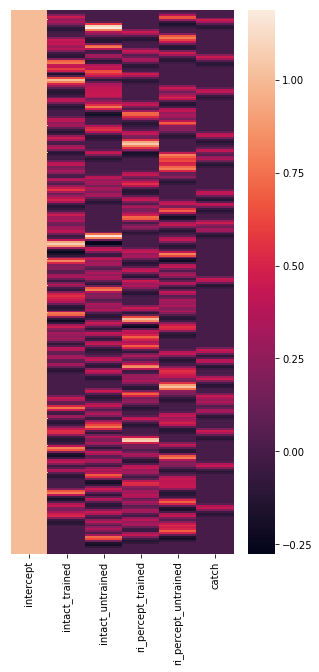

In [131]:
fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(design_matrix,
            xticklabels= ['intercept'] + [i['regname'] for i in onset_dicts],
            yticklabels=[])

# Calculate efficiency

Notes on matrix algebra in numpy

- design_matrix.T is equivalent to np.transpose(design_matrix)
- use np.dot() for multiplication of TWO matrices.
- for multiplication of more than two matrices, use dot several times
- or use matrix.dot() method, e.g. matrix1.dot(matrix2).dot(matrix3)
- use np.linalg.inv() for matrix inverse

In [132]:
# construct constrast matrix

# intact > ri_percept
cvec1 = np.array([0,1,1,-1,-1,0])
# intact < ri_percept
cvec2 = np.array([0,-1,-1,1,1,0])
# ri_trained > ri_untrained
cvec3 = np.array([0,0,0,1,-1,0])
# ri_trained < ri_untrained
cvec4 = np.array([0,0,0,-1,1,0])

# stack arrays into contrast matrix
cmat = np.vstack((cvec1, cvec2, cvec3, cvec4))

In [133]:
cmat

array([[ 0,  1,  1, -1, -1,  0],
       [ 0, -1, -1,  1,  1,  0],
       [ 0,  0,  0,  1, -1,  0],
       [ 0,  0,  0, -1,  1,  0]])

In [134]:
def efficiency(design_matrix, contrast_matrix):
    """
    TODO: make this flexible for single contrast vectors as well
    """
    eff = 1 / np.trace(
        contrast_matrix.dot(np.linalg.inv(design_matrix.T.dot(design_matrix))).dot(contrast_matrix.T))
    return eff

In [136]:
efficiency(design_matrix, cmat)

1.834286639341828

# Variance inflation factor

VIF is a measure for multicolinearity in the design matrix. It is independent of the specified contrasts. VIF values should be < 5.

Computed by ...

- omiting intercept from design matrix
- computing correlation matrix between regressors
- take inverse
- extract diagonal

In [137]:
def compute_vif(design_matrix):
    """
    TODO: docstring
    """
    # omit intercept
    design_matrix_omitted = design_matrix[:,1:]
    # calculate vif
    vif = np.diagonal(np.linalg.inv(np.corrcoef(design_matrix_omitted, rowvar=False)))
    return vif

In [138]:
vif = compute_vif(design_matrix)
print(vif)

[2.19547942 2.14702751 2.14268983 2.1912603  1.45707586]


# Iterate over some simulated runs

simulating 100 designs took me about 10 seconds in this notebook

In [139]:
def iterate_over_designs(niters=100, maxiti=1.5, miniti=0.8, aviti=1.0):

    effs, vifs = [], []

    for i in range(niters):
        stim_seq, catchpositions = simulate_run_bothtypes(percept_dicts, intact_dicts, exp_info,
                                          maxjit=maxiti, minjit=miniti, avjit=aviti)
        stim_seq = add_ons_dur_inten(stim_seq)
        onsetdicts = extract_onsets(stim_seq)
        designmatrix = construct_design_matrix(onsetdicts)
        effs.append(efficiency(contrast_matrix=cmat, design_matrix=designmatrix))
        vifs.append(compute_vif(designmatrix))
        
    return effs, vifs

In [140]:
effs, vifs = iterate_over_designs()

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


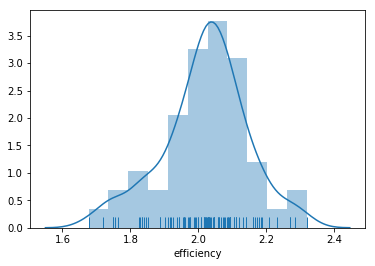

In [141]:
sns.distplot(effs, rug=True, axlabel='efficiency')

## Vary max iti

The code below may take a while to run.

In [48]:
iti_effs_max = []

for itimax in [1.5, 2.0, 3.0]:
    effs, vifs = iterate_over_designs(maxiti=itimax, niters=1000)
    iti_effs_max.append(effs)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


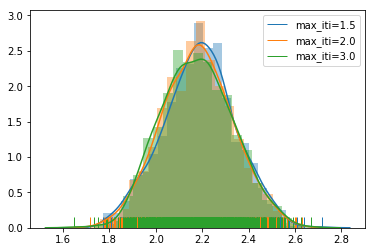

In [49]:
for itieff in iti_effs_max:
    sns.distplot(itieff, rug=True)
    plt.legend(['max_iti=1.5', 'max_iti=2.0', 'max_iti=3.0'])

In [50]:
for i in iti_effs_max:
    print(np.max(i))

2.7173956716881875
2.6278215150501456
2.6707543726008476


## Vary mean iti

In [51]:
iti_effs_mean = []

for itimean in [1.0, 1.5, 2.0]:
    effs, vifs = iterate_over_designs(maxiti=itimax, niters=1000)
    iti_effs_mean.append(effs)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


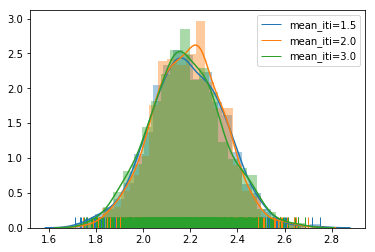

In [52]:
for itieff in iti_effs_mean:
    sns.distplot(itieff, rug=True)
    plt.legend(['mean_iti=1.5', 'mean_iti=2.0', 'mean_iti=3.0'])

In [53]:
for i in iti_effs_mean:
    print(np.max(i))

2.7511180408376728
2.699359828888494
2.6863256362264942


# Load pre-run results

In [68]:
def read_designopt_json(results_filepath='results_design_opt.json'):
    """
    Read json file that contains the results from the design optimation procedure
    
    NOTE: the best designs are at the end of the lists
    """
    import json
    with open(results_filepath, 'rb') as f:
        results = json.load(f)
    return results

In [85]:
simresults = read_designopt_json()
print(simresults.keys())

[u'vifs', u'aviti', u'efficiencies', u'sequences', u'niters', u'maxiti', u'miniti']


In [56]:
def read_trained_obs(behav_data_dir='./behav_data',
                     sub_id='p1'):
    """
    Get the set of trained objects from the behavioral results csv file
    for a given subject.
    """
    import pandas as pd
    fname = '%s/sub%s_behav.csv' % (behav_data_dir, sub_id)
    behav_df = pd.read_csv(fname)
    trained_obs = np.unique(behav_res.object_name)
    return trained_obs

In [84]:
trained_obs = read_trained_obs()
print(trained_obs)

['Dose' 'Ente' 'Gluehbirne' 'Kanne' 'Rahmen' 'Schuh' 'Stift' 'Wuerfel']


In [296]:
def make_optimized_runs_for_sub(sub_id,
                          nruns=3,
                          test=False,
                          behav_data_dir='./behav_data',
                          stim_dir='./Stimuli',
                          designopt_json='results_design_opt.json'):
    """
    From the efficiency optimized trial sequences, grab as many as we want there to be functional runs
    and bring them in shape for presentation with psychopy.
    
    --Notes--
    Each subject gets 3 of the glm optized functional runs.
    The last onset within each of these designs is at about 550 seconds (~9:10 minutes).
    sub_id looks like '01' for real subjects, and is 'p1' for testing purposes.
    subject 1 gets the best sequences, the next subject the next best, etc.
    (remember, best designs are at end of the array).
    """
    
    # get sub_int from sub_id
    if test:
        sub_int = 1
    else:
        sub_int = int(sub_id)
        
    # get designs for this subject
    designopt_results = read_designopt_json(results_filepath=designopt_json)
    if sub_int==1:
        sub_sequences = designopt_results['sequences'][(-(sub_int*nruns)):]
    else:
        sub_sequences = designopt_results['sequences'][(-(sub_int*nruns)):(-(sub_int-1)*nruns)]
    assert len(sub_sequences) == nruns
            
    """
    create seperate lists of dicts for ri and intact trained and untrained respectively
    """

    # get percept and intact dicts
    perc_dir = pjoin(stim_dir, 'percepts')
    prep_dir = pjoin(stim_dir, 'preprocessed')
    percept_dicts, intact_dicts = getstims_aloiselection(percepts_dir=perc_dir, preprocessed_dir=prep_dir)
    # get set of trained objects for this subject
    trained_obs = read_trained_obs(sub_id=sub_id, behav_data_dir=behav_data_dir)    
    # initiate empty stimulus lists
    ri_trained, ri_untrained, intact_trained, intact_untrained = [], [], [], []
    
    # go through all percepts and add to trained vs. untrained list
    for perc in percept_dicts:
        if perc['object_name'] in trained_obs:
            ri_trained.append(perc)
        else:
            ri_untrained.append(perc)
    assert len(ri_trained) == 64
    assert len(ri_untrained) == 64
    # same for intact stimuli
    for intact in intact_dicts:
        if intact['object_name'] in trained_obs:
            intact_trained.append(intact)
        else:
            intact_untrained.append(intact)
    assert len(intact_trained) == 64
    assert len(intact_untrained) == 64
    
    # shuffle those lists
    for stimlist in [ri_trained, ri_untrained, intact_trained, intact_untrained]:
        random.shuffle(stimlist)
        
    """
    Go through the trials and add information of a stimulus
    that matches the training and vision
    """
    # go through the runs / sequences
    for sequence in sub_sequences:
        # indices
        ri_trained_i, ri_untrained_i, intact_trained_i, intact_untrained_i = 0,0,0,0
        for design_trial in sequence:
            
            # add correct block number
            design_trial['block'] = sub_sequences.index(sequence) + 1
            
            # repeat previous trial if this is a catch
            if design_trial['trial_type'] == 'catch':
                assert sequence.index(design_trial) > 0
                # grab last trial
                stimdict = sequence[sequence.index(design_trial) - 1]
                # add the information to design sequence
                design_trial.update(stimdict)
                # mark as catch
                design_trial['trial_type'] = 'catch'
            
            # normal trials
            else:
                # trained ri
                if design_trial['training'] == 'trained' and design_trial['vision'] == 'ri_percept':
                    stimdict = ri_trained[ri_trained_i]
                    ri_trained_i +=1
                # untrained ri
                elif design_trial['training'] == 'untrained' and design_trial['vision'] == 'ri_percept':
                    stimdict = ri_untrained[ri_untrained_i]
                    ri_untrained_i +=1
                # trained intact
                elif design_trial['training'] == 'trained' and design_trial['vision'] == 'intact':
                    stimdict = intact_trained[intact_trained_i]
                    intact_trained_i += 1
                # untrained intact
                elif design_trial['training'] == 'untrained' and design_trial['vision'] == 'intact':
                    stimdict = intact_untrained[intact_untrained_i]
                    intact_untrained_i +=1

                # add the information to design sequence
                design_trial.update(stimdict)

        # check if we have actually gone through all the stimuli with our indices
        for idx in [ri_trained_i, ri_untrained_i, intact_trained_i, intact_untrained_i]:
            assert idx == len(percept_dicts) / 2
            
        # add responses, block info, etc. 
        sequence = add_empty_responses(sequence, add_empty_onset=False, add_trial_num=False)
    
    return sub_sequences

In [297]:
# test this function
sub_sequences = make_optimized_runs_for_sub(sub_id='p1', test=True)

# Plot best design matrix

Should look more blocky

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Text(0.5,1,'best design matrix')

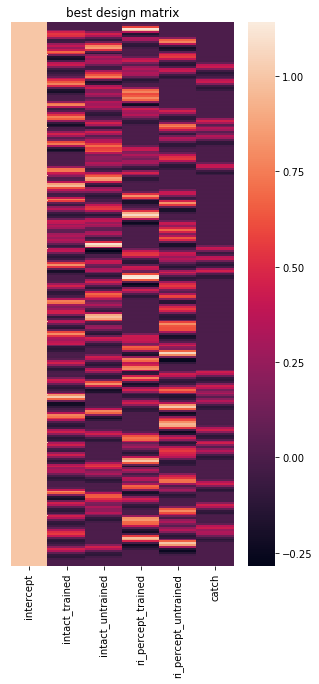

In [83]:
# get best design matrix from simulated sequences
best_seq = simresults['sequences'][-1]
best_seq_withons = add_ons_dur_inten(best_seq)
best_onsets = extract_onsets(best_seq_withons)
best_design_mat = construct_design_matrix(best_onsets)

# plot
fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(best_design_mat,
            xticklabels= ['intercept'] + [i['regname'] for i in best_onsets], yticklabels=[])
plt.title('best design matrix')